In [8]:
# Library imports

from __future__ import annotations

from dataclasses import dataclass, asdict
from pathlib import Path
import hashlib
import json
import numpy as np
import pandas as pd
import pyarrow.dataset as ps
import glob
import os
import matplotlib.pyplot as plt
import random
import time

from openpyxl import load_workbook
import xlsxwriter as xw

In [ ]:
@dataclass
class CommunityProfile:
    name: str
    load_profile: pd.DataFrame

In [ ]:
# Define the file pattern to search for the RESSTOCK *.Parquet files
DATA_DIR = "../data/"

# Define input data directories
INPUT_DATA_DIR = os.path.join(DATA_DIR, "input/")

# COMMSTOCK directories
INPUT_DATA_DIR_COMSTOCK = os.path.join(INPUT_DATA_DIR, "comstock/")
INPUT_DATA_DIR_COMSTOCK_BUILDINGPROFILES = os.path.join(INPUT_DATA_DIR_COMSTOCK, "timeseries_individual_buildings/")

# Define output data directories
OUTPUT_DATA_DIR = os.path.join(DATA_DIR, "output/")

In [ ]:
# "0" is baseline scenario
UPGRADE = "0"

# Washington, DC
STATE = "DC"

file_pattern = os.path.join(DATA_INPUT_DATA_DIR_COMSTOCK_BUILDINGPROFILES, f"upgrade={UPGRADE}/state={STATE}/", "*.parquet")

# Get a list of all file names matching the pattern
all_files = glob.glob(file_pattern, recursive=True)

Time taken for processing 2 runs: 0.1327862540880839 minutes


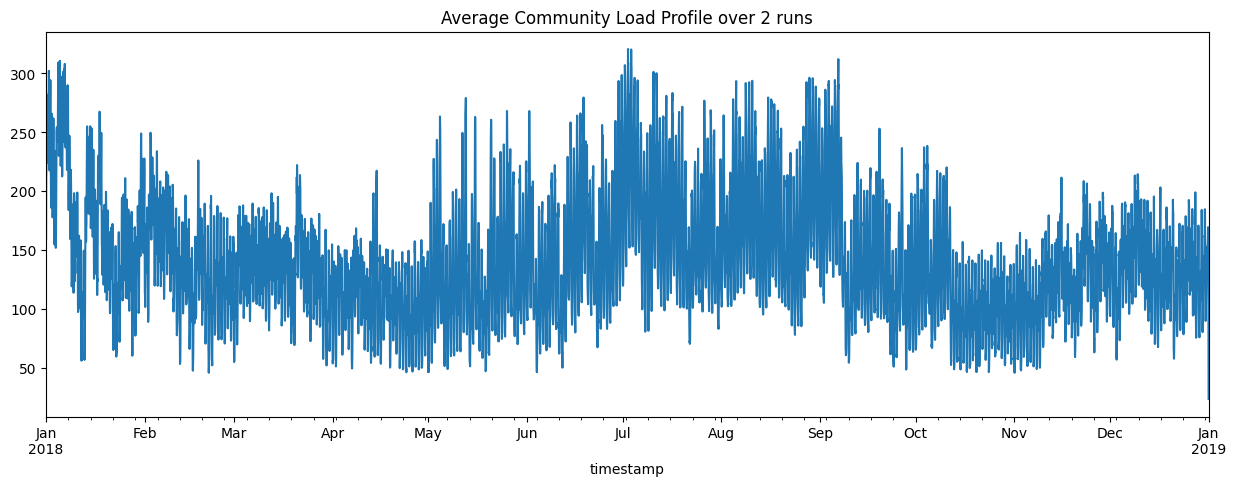

In [ ]:
total_merged_buildings_hourly_list = []

start_time = time.time()

timestamp_str = str(start_time)

DIR = './data/scenario_runs/'
if not os.path.exists(f'{DIR}{timestamp_str}/'):
    os.makedirs(f'{DIR}{timestamp_str}/')
SAMPLE_RUNS = 2
mean = 1
mu = 1.5
ADJUSTMENT_MULTIPLIER = np.random.normal(mean, mu, size=SAMPLE_RUNS)


for i in range(0,SAMPLE_RUNS):

    chosen_files = random.choices(all_files, k=100)

    chosen_files_df = pd.DataFrame(chosen_files, columns=['filename'])
    chosen_files_df.to_csv(f'{DIR}{timestamp_str}/chosen_files.csv')

    ## TODO Add choices for each run into csv for further analysis.


    # Create a list of DataFrames, one for each file
    df_list = [pd.read_parquet(filename) for filename in chosen_files]

    # Concatenate all DataFrames in the list into a single DataFrame
    merged_df = pd.concat(df_list, ignore_index=True)

    merged_buildings_15m = merged_df[['timestamp', 'out.electricity.total.energy_consumption..kwh', 'bldg_id', 'in.sqft']]
    merged_buildings_15m.index = pd.to_datetime(merged_buildings_15m['timestamp'])
    merged_buildings_hourly = merged_buildings_15m.resample('h')['out.electricity.total.energy_consumption..kwh'].sum() * ADJUSTMENT_MULTIPLIER[i]
    ax_merged_buildings_hourly = merged_buildings_hourly.plot(x='timestamp', y='out.electricity.total.energy_consumption..kwh')

    total_merged_buildings_hourly_list.append(merged_buildings_hourly)
    merged_buildings_hourly.to_csv(f'{DIR}{timestamp_str}/merged_community_load_profile_{timestamp_str}_run-{i+1}.csv')

ax_merged_buildings_hourly.get_figure().savefig(f'{DIR}{timestamp_str}/merged_community_load_profile_total.png')
plt.close(ax_merged_buildings_hourly.get_figure())

total_merged_buildings_hourly = pd.concat(total_merged_buildings_hourly_list)
total_merged_buildings_hourly.to_csv(f'{DIR}{timestamp_str}/merged_community_load_profile_{timestamp_str}_total.csv')
total_merged_buildings_hourly_average = total_merged_buildings_hourly.groupby(total_merged_buildings_hourly.index).mean()

ax_total_merged_buildings_hourly_average = total_merged_buildings_hourly_average.plot(x='timestamp', y='out.electricity.total.energy_consumption..kwh', figsize=(15,5))
ax_total_merged_buildings_hourly_average.get_figure().savefig(f'{DIR}{timestamp_str}/merged_community_load_profile_{timestamp_str}_average.png')
ax_total_merged_buildings_hourly_average.set_title('Average Community Load Profile over ' + str(SAMPLE_RUNS) + ' runs')

end_time = time.time() 

time_diff = end_time - start_time
print(f"Time taken for processing {SAMPLE_RUNS} runs: {time_diff/60.0} minutes")
#total_merged_buildings_daily.head()
total_merged_buildings_daily_total = total_merged_buildings_hourly_average.resample('D').sum()
total_merged_buildings_daily_total.to_csv(f'{DIR}{timestamp_str}/merged_community_load_profile_{timestamp_str}_total_daily.csv')
total_merged_buildings_monthly_total = total_merged_buildings_hourly_average.resample('ME').sum()
total_merged_buildings_monthly_total.to_csv(f'{DIR}{timestamp_str}/merged_community_load_profile_{timestamp_str}_total_monthly.csv')

workbook = xw.Workbook(f'{DIR}{timestamp_str}/output.xlsx')
worksheet = workbook.add_worksheet('Overview')

row = 0
col = 0

worksheet.write(row, col, 'TimeStart (timestamp)')
worksheet.write(row+1, col, str(start_time))
worksheet.write(row, col+1, 'TimeEnd (timestamp)')
worksheet.write(row+1, col+1, str(end_time))
worksheet.write(row, col+2, 'TimeDiff (minutes)')
worksheet.write(row+1, col+2, str(time_diff/60.0))

workbook.close()

# # Open the existing file in append mode
# with pd.ExcelWriter(f'{DIR}{timestamp_str}/output.xlsx', mode='a', engine='openpyxl', if_sheet_exists='new') as writer:
#     df3.to_excel(writer, sheet_name='Sheet3_Veggies', index=False)

In [147]:
#df_weather = pd.read_csv('./data/weather/USA_DC_Washington.National.AP.725030_TMY3.csv')
df_weather = pd.read_csv('./data/G1100010_2018.csv')
df_weather['date_time'] = pd.to_datetime(df_weather['date_time'], format='%m/%d/%y %H:%M')
df_weather.set_index(df_weather['date_time'])
df_weather_daily = df_weather.resample('d', on='date_time').mean()
df_weather_daily.head()
df_weather_daily.to_csv(f'{DIR}amy2018_average_monthly.csv')



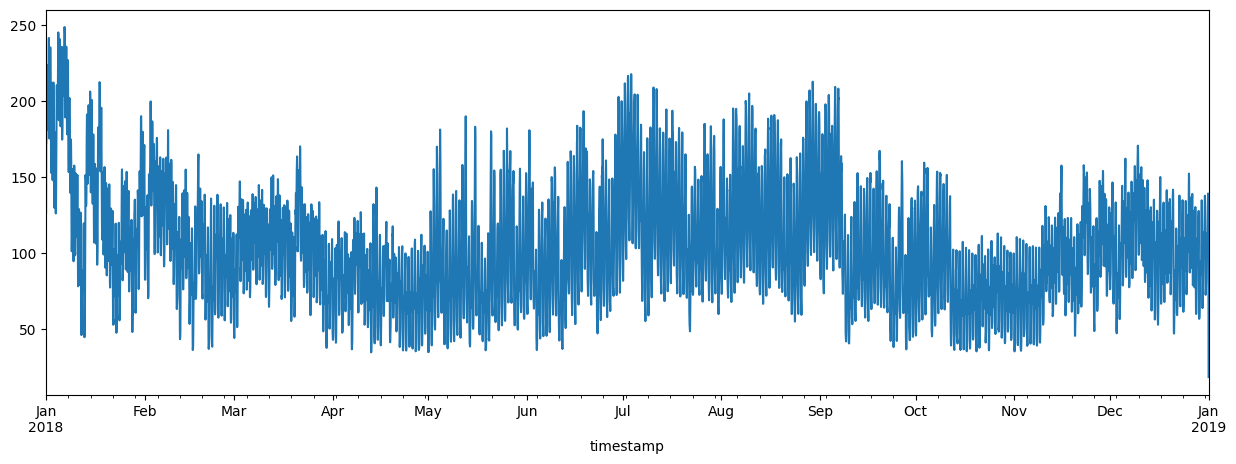

In [ ]:
total_merged_buildings_hourly = pd.concat(total_merged_buildings_hourly_list)
total_merged_buildings_hourly.to_csv(f'total_merged_community_load_profile_{timestamp_str}.csv')
total_merged_buildings_hourly_average = total_merged_buildings_hourly.groupby(total_merged_buildings_hourly.index).mean()
ax_total_merged_buildings_hourly_average = total_merged_buildings_hourly_average.plot(x='timestamp', y='out.electricity.total.energy_consumption..kwh', figsize=(15,5))

fig2 = ax_total_merged_buildings_hourly_average.get_figure()
fig2.savefig(f'community_load_profile_{timestamp_str}.png')


type:  <class 'pandas.core.series.Series'>


/var/folders/cl/bn539g3s0_b18p8wwzsg6xmr0000gn/T/ipykernel_65600/2455979868.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_test_building['out.electricity.total.energy_consumption..kwh'] = new_test_building['out.electricity.total.energy_consumption..kwh'] * 100.0


<Axes: xlabel='timestamp'>

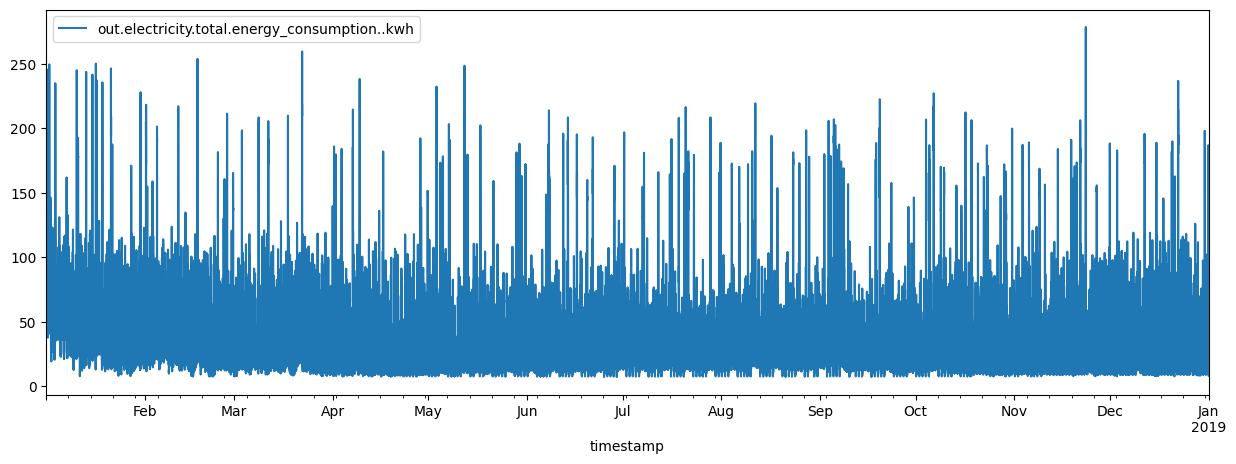

In [4]:
test_building = pd.read_parquet('./data/timeseries_individual_buildings/upgrade=0/state=DC/549845-0.parquet')

test_building.columns[test_building.columns.str.contains('total')].to_list()


new_test_building = test_building[['timestamp','out.electricity.total.energy_consumption..kwh']]
print("type: ", type(new_test_building['timestamp']))
new_test_building['out.electricity.total.energy_consumption..kwh'] = new_test_building['out.electricity.total.energy_consumption..kwh'] * 100.0
new_test_building.plot(x='timestamp', y='out.electricity.total.energy_consumption..kwh', figsize=(15,5))





15min


timestamp
2018-01-01 00:00:00    141.339005
2018-01-01 01:00:00    194.477997
2018-01-01 02:00:00    196.528992
2018-01-01 03:00:00    197.660004
2018-01-01 04:00:00    196.583008
Freq: h, Name: out.electricity.total.energy_consumption..kwh, dtype: float32

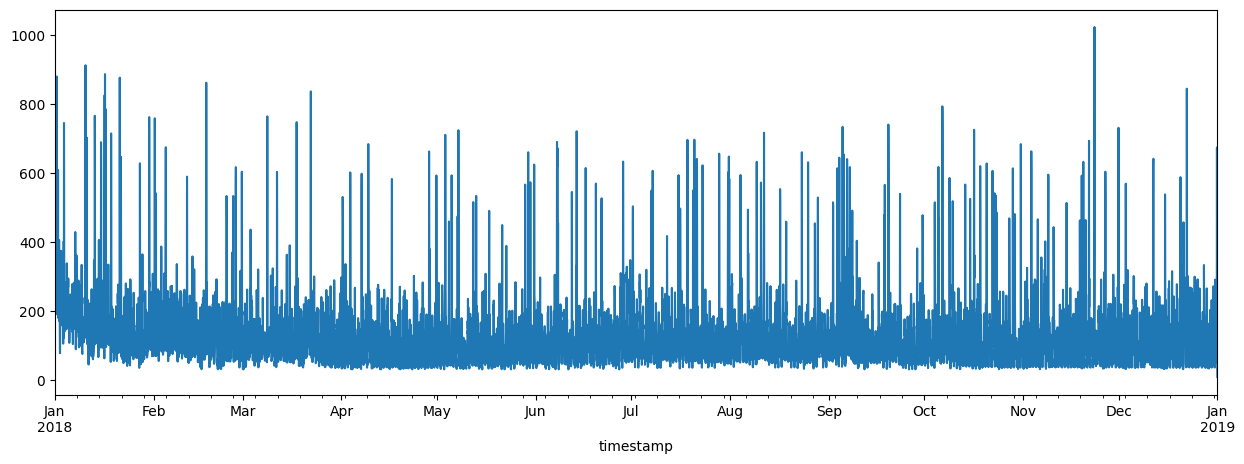

In [5]:
new_test_building.index = pd.to_datetime(new_test_building['timestamp'])
print(pd.infer_freq(new_test_building.index))
new_test_building_hourly = new_test_building.resample('h')['out.electricity.total.energy_consumption..kwh'].sum()

new_test_building_hourly.plot(x='timestamp', y='out.electricity.total.energy_consumption..kwh', figsize=(15,5))

new_test_building_hourly.head()

<Axes: xlabel='Ascending'>

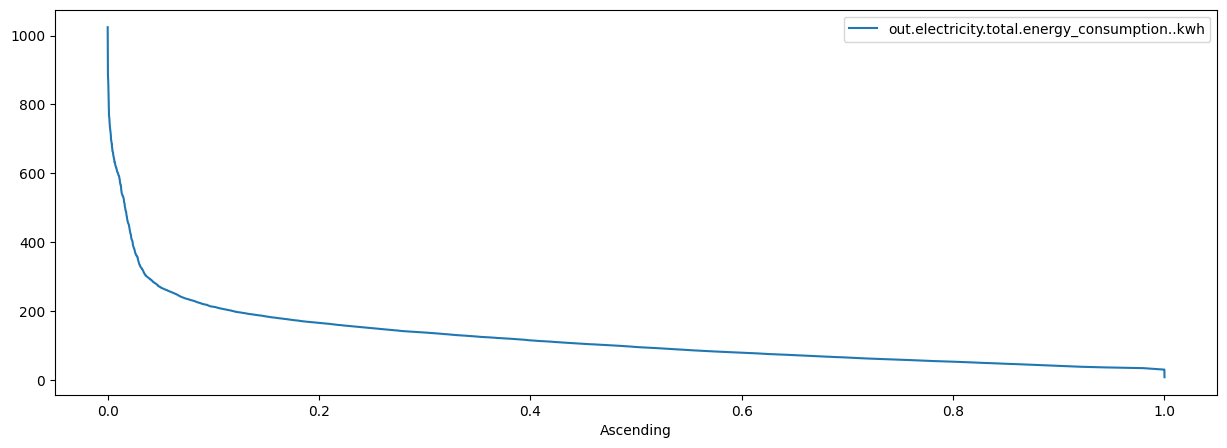

In [34]:
new_test_building_hourly_sorted = new_test_building_hourly.sort_values(ascending=False)
new_test_building_hourly_sorted = new_test_building_hourly_sorted.reset_index()
new_test_building_hourly_sorted['Ascending'] = np.arange(1, len(new_test_building_hourly_sorted) + 1) / 8760.0
new_test_building_hourly_sorted

new_test_building_hourly_sorted.plot(x='Ascending', y='out.electricity.total.energy_consumption..kwh', figsize=(15,5))